# Make efficiency map plots for trained fitters

In [1]:
import train as tn
reload(tn)

import plotting
reload(plotting)

import util as ut

import matplotlib.pyplot as plt
#plt.style.use('seaborn-ticks')
plt.style.use('seaborn-poster')
%matplotlib inline
#%matplotlib notebook

import numpy as np

from pprint import pprint

import itertools

# import xgboost

Welcome to ROOTaaS 6.06/08


In [2]:
#note that the loading option is True by default
ut.defaultParameters(dataDir='./data', inputName="effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out", inputDir='./classifiers')
ut.setParams()
effFitter = ut.loadOrMake()

entered config files named my_train_config
None
Load object with the name effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out and the following paramters 
{'classifiers': [],
 'clean': [],
 'dataDir': './data',
 'dataFname': 'output_InsideAcceptance_125.root',
 'defineBins': {},
 'forceMake': False,
 'genBranches': ['genPt',
                 'genRapidity',
                 'genJet2p5Pt0',
                 'genJet2p5Rapidity0',
                 'genJet2p5Pt1',
                 'genJet2p5Rapidity1',
                 'genJet2p5Pt2',
                 'genJet2p5Rapidity2',
                 'genJet2p5Pt3',
                 'genJet2p5Rapidity3',
                 'weight',
                 'genNjets2p5'],
 'inputDir': './classifiers',
 'inputName': 'effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out',
 'load': True,
 'ncats': 3,
 'outDir': '.',
 'outName': 'effFitter_out',
 'pfx': 'genDiphotonDumper/trees/InsideAcceptance_125_13TeV',
 'recoBranches': ['recoPt', 'recoRapidity', 'recoNjets2p5'],
 'rn

### define bins in genJet2p5Rapidity0 and genJet2p5Pt0

In [3]:
 defineBins = { 'genJet2p5Rapidity0' : dict(boundaries=[-5.,-2.,0.,2.,5.],overflow=False), # do not add overflow automatically
                'genJet2p5Pt0' : dict(boundaries=[0.,50.,100.,200.,1000.],overflow=False)
            }   

In [4]:
ut.runDefineBins(effFitter,defineBins)

### Extract data frame and start getting the probas in a binned way

In [5]:
df = effFitter.df
first_train_evt = int(round(df.index.size*(1.-effFitter.split_frac)))
df_test = df[:first_train_evt]

In [6]:
def weighted_average(df_name, column_name, weight_name=None):
    """
    This function computes the weighted average of the quantity column_name
    stared in the pandas dataframe df_name. In case no weights are given
    or if they sum up to zero, the mean is returned instead.
    :params 
            df_name :
        column_name :
        weight_name :
    :retruns
                    :
    """
    d = df_name[column_name]
    w = df_name[weight_name]
    if (weight_name == None) :
        return float(d.mean())
    else :
        try:
            return (d * w).sum() / float(w.sum())
        except ZeroDivisionError:
            return float(d.mean())

In [7]:
gb_proba = df_test.groupby(['genJet2p5Rapidity0Bin','genJet2p5Pt0Bin']).apply(weighted_average,"recoNjets2p5Cat_prob_5",'absweight')

### get the "true" probability in each bin by computing the frequency of each event

In [8]:
print(df_test['genJet2p5Rapidity0Bin'].min())
print(df_test['genJet2p5Rapidity0Bin'].max())
print(df_test['genJet2p5Pt0Bin'].min())
print(df_test['genJet2p5Pt0Bin'].max())


0
3
nan
3


In [9]:
df_test[['genJet2p5Pt0Bin','genJet2p5Rapidity0Bin','genJet2p5Pt0','genJet2p5Rapidity0']][0:5]

,genJet2p5Pt0Bin,genJet2p5Rapidity0Bin,genJet2p5Pt0,genJet2p5Rapidity0
random_index,,,,
0,1.0,0,84.751411,-2.179922
1,NaN,1,0.000000,0.000000
2,0.0,1,41.552631,-1.585931
3,0.0,1,47.969078,-0.009925
4,1.0,2,68.500809,0.725095


In [10]:
p = df_test['genJet2p5Pt0Bin'][1]

In [11]:
type(p)

numpy.float64

In [12]:
p

nan

In [13]:
df_cat_5 = df_test[df_test['recoNjets2p5Cat']==5]

In [14]:
norm = df_cat_5.shape[0]

In [15]:
norm

38479

how many events are nan, i.e. not reconstructed?

In [16]:
not_reco = len(df_cat_5[ (df_cat_5['genJet2p5Pt0'] == 0.) & (df_cat_5['genJet2p5Rapidity0'] == 0.) ] )

In [17]:
norm - not_reco

34921

In [18]:
def weighted_freq (df_name, column_name, equal_to, weight_name, norm) :
    df = df_name#[df_name[column_name]==equal_to]
    
    #print(df.shape[0])
    w = df[weight_name]
    #print(w)
    return float(len(w)) / norm

In [76]:
def effPlotNjets (groupby_object) :
    
    r = groupby_object
    z = r.values
    x,y = r.index.levels
    #X,Y = np.meshgrid(x,y)
    Z = z.reshape(len(x),len(y))
    
    x_labels = np.arange(len(x))
    y_labels = np.arange(len(y))
  
    #print(X)
    #print(Y)
    
    fig, ax = plt.subplots()
    for (i, j), p in np.ndenumerate(Z):
        p = p*100
        ax.text(j+.5, i+.5, '{:0.1f}'.format(p), ha='center', va='center')
    plt.pcolormesh(Z)
 
    """
    plt.axis([x.min(),x.max(),y.min(),y.max()])
  
    plt.xlim(x.min()-.5,x.max()+.5)
    plt.ylim(y.min()-.5,y.max()+.5)
    
    plt.xticks(np.arange(len(x)))
    plt.yticks(np.arange(len(y)))
    """
    plt.show()

In [31]:
gb_freq = df_cat_5.groupby(['genJet2p5Rapidity0Bin','genJet2p5Pt0Bin']).apply(weighted_freq,"recoNjets2p5Cat",0,'absweight',norm)

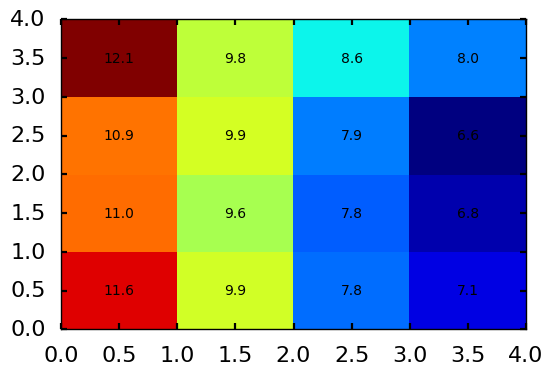

In [77]:
effPlotNjets(gb_proba)

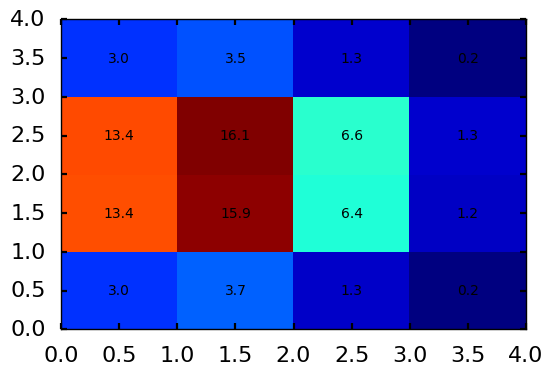

In [78]:
effPlotNjets(gb_freq)